In [1]:
%autosave 1
import numpy as np
import warnings
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.constants import hbar
warnings.filterwarnings("ignore")

from copy import deepcopy

Autosaving every 1 seconds


[Libreria di riferimento](http://weinbe58.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html)

We want to write a chain of L coupled qubits:
$$H[h_x(t)] = - \sum_{j=1}^L(JS^z_{j+1}S^z_j+gS^z_j+h_x(t)S^x_j)$$
as in the article we set g=1. 

In the particoular case of single qubit we remove the first term J=0: 

$$H[h_x(t)] = - S^z_j - h_x(t)S^x_j$$

In [2]:
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

In [3]:
hamiltonian_plus4 = -sigma3-4*sigma1
hamiltonian_minus4 = -sigma3+4*sigma1
val_H_plus4,vec__H_plus4, = LA.eig(hamiltonian_plus4)
val_H_minus4,vec__H_minus4, = LA.eig(hamiltonian_minus4)

**STOCHASTIC DESCENT**
1. Start from a random protocol and proposes local field updates at time t choosing uniformly in the interval [0,T].
2. Magnetic field is changed only if increase the fidelity.
3. Number of fidelity evaluation at most $$20 \times T/\delta t$$
4. Repeat with different initial random protocols.

The set of protocols {$h^{\alpha}|\alpha= 1, \dots, N_{real}$} used to calculate the glass-like order parameter.

In [4]:
def modulus_squared_inner_product(psi1,psi2):
    modulus=np.abs(np.dot(np.conj(psi1.T),psi2))
    return modulus**2
def fidelity(psi_target,psi_rec):
    return modulus_squared_inner_product(psi_target, psi_rec)
def infidelity(psi_target,psi_rec):
    return 1 - modulus_squared_inner_product(psi_target, psi_rec)

def update_state(eigenvectors,eigenvalues,psi_in,T):
    c_i = np.array([np.dot(eigenvectors[:,i],psi_in) for i in range(len(psi_in))]) 
    psi_rec = []
    for i in range(len(psi_in)):
        psi_rec.append(c_i[i]*np.exp((-1j*eigenvalues[i]*T)/hbar)*eigenvectors[i])
    return np.array(psi_rec).sum(axis=0)

In [5]:
TMAX = 1
Δt = 0.01
NSTEPS = int(TMAX/Δt)
ITERATIONS = int(1e3)

print("Total time of the protocol:", TMAX)
print("Time step:", Δt)
print("Number of timesteps:", NSTEPS)

LIMIT_FED_EVAL=20*TMAX/Δt # set by paper authors

Total time of the protocol: 1
Time step: 0.01
Number of timesteps: 100


**SPECTRAL METHOD**

First method to evolve the system:

$$|\psi(T)> = \sum_{i=0}^{L-1} c_i exp[-i E_i T / \hbar] |E_i>$$

In [6]:
from random import choices
from random import uniform
from tqdm import tnrange

np.random.seed(213)

hx = [-4,4]

random_protocol = np.array(choices(hx, k=NSTEPS)) # Define a random protocol, sampling without replacement from a list. 
temp_protocol=deepcopy(random_protocol)

psi_start = np.array([1 + 0.j, 0 + 0.j], dtype=complex)
psi_iniz = deepcopy(psi_start)
psi_target = np.array([0. + 0.j,1 + 0.j], dtype=complex)


'''angle_phase_iniz = uniform(0,2*np.pi)
angle_phase_target = uniform(0,2*np.pi) 
first_coefficient = np.random.uniform(0, 1)
second_coefficient = np.sqrt(1-first_coefficient**2)
psi_iniz = np.array([first_coefficient,second_coefficient*np.exp(1j*angle_phase_iniz)]) # Start from a random state 2D
psi_target = 1/np.sqrt(2)*np.array([1,1*np.exp(1j*angle_phase_target)])# Remember to change first component when things will work.'''

fidelity = modulus_squared_inner_product(psi_target,psi_start)
fidelity_values = [fidelity]

In [7]:
warnings.filterwarnings("ignore")
percentage_flip=20


for j in tnrange(ITERATIONS):
    psi_iniz=deepcopy(psi_start)
    index_update = np.random.randint(0, NSTEPS-1,size=int(NSTEPS/100*percentage_flip)) # Select an index for the update.
    temp_protocol[index_update] = random_protocol[index_update]*(-1) # Try to update that index.
    
    #print("NORMALIZATION BEFORE : ",modulus_squared_inner_product(psi_iniz,psi_iniz))

    for i in temp_protocol:  # Evolve the random state according to the protocol
        if i<0:
            psi_iniz = update_state(vec__H_minus4,val_H_minus4, psi_iniz,Δt)
        else:
            psi_iniz = update_state(vec__H_plus4,val_H_plus4, psi_iniz,Δt)
            
    #print("NORMALIZATION AFTER : ",modulus_squared_inner_product(psi_iniz,psi_iniz))
    
    #fidelity = modulus_squared_inner_product(psi_target,psi_iniz)
    temp_fidelity = modulus_squared_inner_product(psi_target,psi_iniz) # Evaluate the fidelity
    if temp_fidelity>fidelity: # Update the change only if better fidelity
        #psi_iniz = temp_psi_iniz 
        random_protocol=deepcopy(temp_protocol)
        fidelity=temp_fidelity
        print("HO AGGIORNATO  ", "ITERATION N°",j )
    fidelity_values.append(fidelity)

# saved_param_adam = np.array(saved_param_adam).transpose()
# np.savetxt('Model_2_lambdas_iterations.txt', saved_param_adam, delimiter = ',',header="Each column is the set of the lambda parameters, the first column refers to the first iteration and so forth.")

    

HO AGGIORNATO   ITERATION N° 0
HO AGGIORNATO   ITERATION N° 1
HO AGGIORNATO   ITERATION N° 3
HO AGGIORNATO   ITERATION N° 17
HO AGGIORNATO   ITERATION N° 21



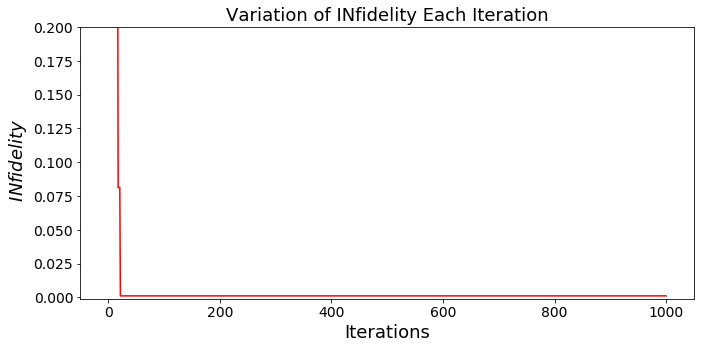

In [8]:
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(np.array(1-np.array(fidelity_values)),color='r')
ax.set_ylim([-0.001, 0.2])
ax.set_title(r"Variation of INfidelity Each Iteration", fontsize=18)
ax.set_xlabel("Iterations", fontsize=18)
ax.set_ylabel(r" $INfidelity$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14) 

In [9]:
fidelity

0.9988407513701006

In [10]:
from qutip import basis, Bloch
from gif import qutip_qstate
from quantum_state import evolution_from_protocol, time_evolution

In [11]:
qstates = evolution_from_protocol(psi_start, psi_target, random_protocol, time_evolution, Δt, make_gif="g.gif")

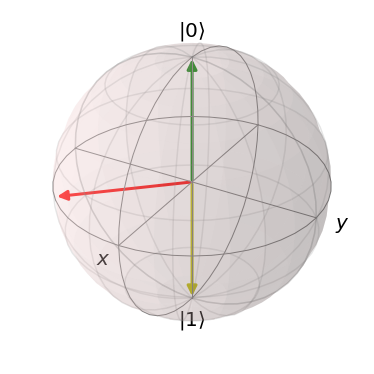

In [12]:
b = Bloch()
qstart = qutip_qstate(psi_start)
qtarget = qutip_qstate(psi_target)
qfinal = qutip_qstate(qstates[-1])
b.vector_color = ["g", "y", "r"]
b.add_states(qstart) #green
b.add_states(qtarget) #yellow
b.add_states(qfinal) #red
b.show()